In [33]:
import splitfolders
splitfolders.ratio('/catclass_ai/fuck/', output="/catclass_ai/output", seed=1337, ratio=(0.9,0.1)) 

Copying files: 1557 files [00:00, 4391.13 files/s]


In [28]:
import numpy as np
import librosa
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=160, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<int(1.3*sr):
    wav=np.pad(wav,int(np.ceil((1.3*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:int(1.3*sr)]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db


In [29]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [30]:
import matplotlib.pyplot as plt

In [31]:
from keras.utils import load_img, img_to_array

# 이미지 shape, array, 사진 확인하기
def showimg(imgarr):
    plt.imshow(imgarr, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    print(imgarr.shape)

In [34]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/output/train/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
caterwaul_path = train_path


In [35]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/output/train/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_path = train_path


In [36]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/output/val/caterwaul'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
caterwaul_val_path = train_path

In [37]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/output/val/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
meow_val_path = train_path

In [38]:
print(caterwaul_path[0])

/catclass_ai/output/train/caterwaul/7Ek0avZRI6Q_30_113_5.wav


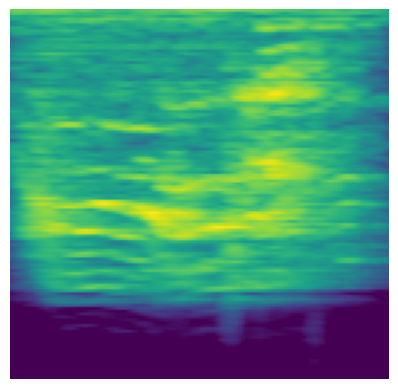

(128, 131)


In [39]:
showimg(spec_to_image(get_melspectrogram_db(str(caterwaul_path[4]))))

In [40]:
from PIL import Image

for i in range(len(caterwaul_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(caterwaul_path[i]))))
    im.save("/catclass_ai/img_data/train/caterwaul/"+str(caterwaul_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [41]:
from PIL import Image

for i in range(len(meow_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_path[i]))))
    im.save("/catclass_ai/img_data/train/meow/"+str(meow_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [42]:
from PIL import Image

for i in range(len(caterwaul_val_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(caterwaul_val_path[i]))))
    im.save("/catclass_ai/img_data/val/caterwaul/"+str(caterwaul_val_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [43]:
from PIL import Image

for i in range(len(meow_val_path)):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(str(meow_val_path[i]))))
    im.save("/catclass_ai/img_data/val/meow/"+str(meow_val_path[i]).split("/")[-1].split(".")[0]+'.jpeg')

In [44]:
from keras.preprocessing.image import ImageDataGenerator

In [45]:
train = ImageDataGenerator(rescale=1/255)
train_dataset = train.flow_from_directory("/catclass_ai/img_data/train/",
                                          target_size=(128,131),
                                          batch_size = 32,
                                          class_mode = 'binary')

Found 1401 images belonging to 2 classes.


In [46]:
# 테스트 데이터 생성하기
test = ImageDataGenerator(rescale=1/255)

test_dataset = test.flow_from_directory("/catclass_ai/img_data/val/",
                                          target_size=(128,131),
                                          batch_size =32,
                                          class_mode = 'binary')

Found 156 images belonging to 2 classes.


In [47]:
train_dataset.class_indices

{'caterwaul': 0, 'meow': 1}

1.0


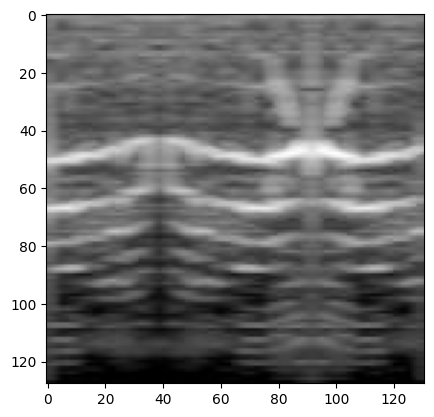

1.0


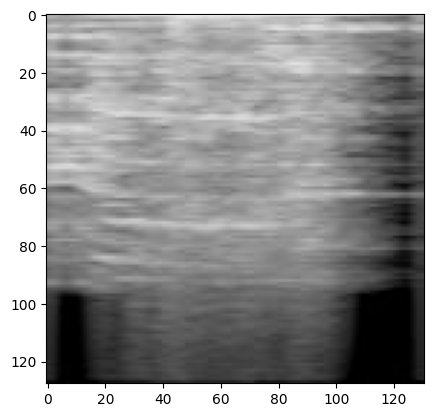

1.0


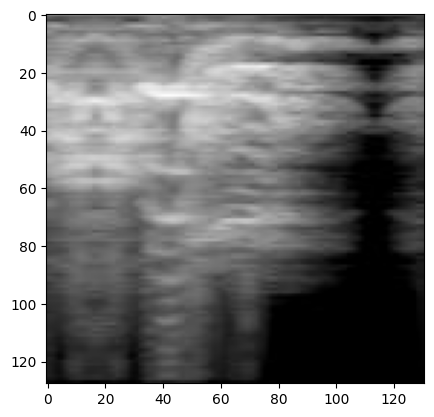

1.0


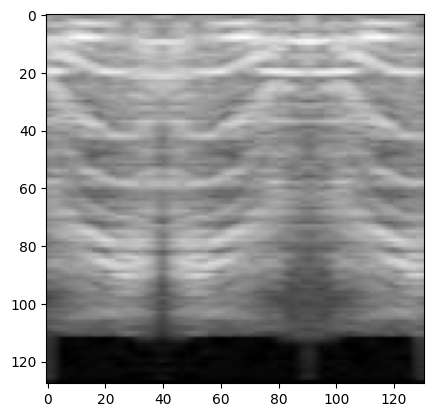

0.0


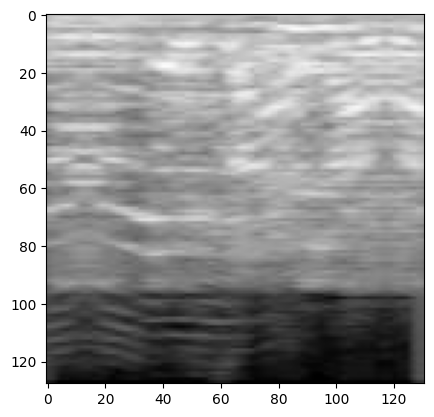

In [48]:
# 학습 데이터 레이블과 이미지 확인하기
for _ in range(5):
    img, label = train_dataset.next()
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [49]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Conv2D, MaxPool2D, Flatten, Dense
import random

In [50]:
model = Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(128,131,3)))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 129, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 64, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 64, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 62, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 31, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 31, 64)       

In [52]:
# model.compile(optimizer = "adam" ,
#               loss = "binary_crossentropy",
#               metrics=["accuracy"])

model.compile(optimizer = "adam" ,
              loss = "sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [53]:
# from keras.callbacks import EarlyStopping

# custom_early_stopping = EarlyStopping(
#     monitor='accuracy',
#     patience=15
# )

#EarlyStopping 사용
from keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    patience=5
)

In [59]:
# 모델 학습

from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체를 생성합니다.
checkpoint = ModelCheckpoint("/catclass_ai/fuck_weights.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

# 모델을 학습합니다. ModelCheckpoint 객체를 콜백으로 전달합니다.

history =  model.fit(train_dataset,
                     epochs=1000,
                     batch_size=32,
                     verbose=1,
                     validation_data = test_dataset,
                     callbacks=[checkpoint])

model.save('/catclass_ai/model_softmax.h5')

Epoch 1/1000
43/44 [============================>.] - ETA: 0s - loss: 0.5423 - sparse_categorical_accuracy: 0.7151
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.69872, saving model to /catclass_ai/fuck_weights.h5
44/44 [==============================] - 1s 33ms/step - loss: 0.5406 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.5740 - val_sparse_categorical_accuracy: 0.6987
Epoch 2/1000
43/44 [============================>.] - ETA: 0s - loss: 0.5062 - sparse_categorical_accuracy: 0.7378
Epoch 2: val_sparse_categorical_accuracy improved from 0.69872 to 0.71795, saving model to /catclass_ai/fuck_weights.h5
44/44 [==============================] - 1s 30ms/step - loss: 0.5089 - sparse_categorical_accuracy: 0.7352 - val_loss: 0.5529 - val_sparse_categorical_accuracy: 0.7179
Epoch 3/1000
43/44 [============================>.] - ETA: 0s - loss: 0.4954 - sparse_categorical_accuracy: 0.7443
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.71795
44/44 [=====

KeyboardInterrupt: 

In [73]:
# model.evaluate로 평가하기
score = model.evaluate(test_dataset, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 13ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.9038
Test loss: 0.5462260842323303
Test accuracy: 0.9038461446762085


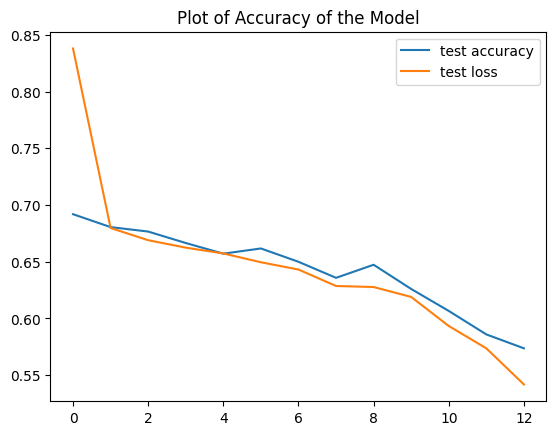

In [74]:
plt.title('Plot of Accuracy of the Model')
plt.plot(history.history['val_loss'], label='test accuracy')
plt.plot(history.history['loss'], label='test loss')
plt.legend()
plt.show()

In [67]:
model.load_weights("/catclass_ai/fuck_weights.h5")

In [72]:
model.save('/catclass_ai/model_fuck.h5')

In [22]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/augmented_data/test/meow'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
test_meow_path = train_path

In [46]:
print(test_meow_path)

['/catclass_ai/augmented_data/test/meow/K4tAuzHXCVw_10_27.wav', '/catclass_ai/augmented_data/test/meow/M7jtDlV39r8_30_92.wav', '/catclass_ai/augmented_data/test/meow/8EmUkaIhr8M_30_269.wav', '/catclass_ai/augmented_data/test/meow/N25QXGVVXog_30_48.wav', '/catclass_ai/augmented_data/test/meow/IyBazGaHPeo_30_199.wav', '/catclass_ai/augmented_data/test/meow/3-Q-3tZRaLI_30_53.wav', '/catclass_ai/augmented_data/test/meow/6zwSfh9rFM8_30_2.wav', '/catclass_ai/augmented_data/test/meow/51I8U2iWrpM_30_55.wav', '/catclass_ai/augmented_data/test/meow/-4o0jRbgHr4_30_110.wav', '/catclass_ai/augmented_data/test/meow/5bf0JVLSIbY_30_83.wav', '/catclass_ai/augmented_data/test/meow/-_8E5aDUqas_30_19.wav', '/catclass_ai/augmented_data/test/meow/5-VdQ476qJ8_30_53.wav', '/catclass_ai/augmented_data/test/meow/BO7DUflFfIc_30_70.wav', '/catclass_ai/augmented_data/test/meow/-ugtQOTQMxM_30_49.wav', '/catclass_ai/augmented_data/test/meow/C0AY0FEhOxU_30_621.wav', '/catclass_ai/augmented_data/test/meow/1yADGwQBDrE_

In [77]:
from glob import glob
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = '/catclass_ai/temp/test4/wav'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp
test_caterwaul_path = train_path

In [76]:
spec_to_image(get_melspectrogram_db(str(test_meow_path[0]))).shape

/tmp/ipykernel_317/872915455.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  wav,sr = librosa.load(file_path,sr=sr)
/root/anaconda3/envs/catclass/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/catclass_ai/temp/test2/wav/test2_49.wav'

In [78]:
from PIL import Image
def model_test(filename):
    im = Image.fromarray(spec_to_image(get_melspectrogram_db(filename)))
    im.save("/catclass_ai/0.jpeg")
    img1 = load_img("/catclass_ai/0.jpeg",target_size=(128,131))
    #plt.imshow(img1)
    imarr = img_to_array(img1)
    X = np.expand_dims(imarr,axis=0)
    val = model.predict(X,verbose=0)
    return val
    # if val == 1:
    #     plt.xlabel("Meow",fontsize=30)
    # elif val == 0:
    #     plt.xlabel("Caterwaul",fontsize=30)

In [81]:
d=[[0,0]]
for i in range(len(test_caterwaul_path)):
    a = (model_test(str(test_caterwaul_path[i])))
    d+=a
print(d)

[[1.72272686e-35 1.32000000e+02]]


1/1 [==============================] - 0s 24ms/step
[[0. 1.]]


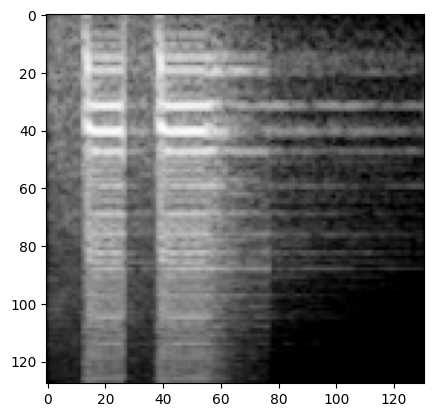

In [36]:
model_test("/catclass_ai/2.wav")